# Convergence test of CTHYB solver parameters

## Overview

The goal of this tutorial is to find out how to choose parameters for the CTHYB solver to obtain better results. The solver parameters can be investigated according to their role in increasing efficiency or accuracy.

#### efficiency                                       
1. `length_cycle` : The number of Monte Carlo moves in a cycle, i.e. the number of moves between performing two consecutive  measurements.

#### accuracy
1. `n_warmup_cycles` : The number of warmup (thermalization) cycles at the very beginning of the simulation where no measurements are made.        
2. `n_cycles` : The total number of QMC measurements.
3. `n_iw` : The number of Matsubara frequencies used for the Green's functions.
4. `n_l` : The number of Legendre polynomials to use in accumulations of the Green’s functions.
5. `n_tau` : The number of imaginary time points used for the Green’s functions.

The results will just give the user an intuition of how to perform the convergence tests for each parameter. Every test needs to be tailored according to the user's case of study.

To run this notebook you need to import the modules below. For installation guide please refer to [TRIQS](https://triqs.github.io/triqs/latest/install.html) and [CTHYB](https://triqs.github.io/cthyb/latest/install.html) webpages.

In [1]:
import numpy as np
from math import pi
from triqs.gf import *
from triqs.plot.mpl_interface import oplot,plt
from matplotlib import pyplot
from triqs.gf import make_gf_from_fourier
from triqs.operators import *
from h5 import *
from h5 import HDFArchive
from triqs_cthyb import Solver
import scipy.optimize as opt
import os
import math
import matplotlib as mpl
from matplotlib.markers import MarkerStyle

# To make plots in interactive mode
%matplotlib inline

# Make all figures slightly bigger
mpl.rcParams['figure.dpi']=120

Starting serial run at: 2022-08-31 14:32:15.008279


In [2]:
from triqs_cthyb.version import show_version
show_version()


You are using triqs_cthyb version 3.1.0



## Efficiency

### 1. `length_cycle`
Number of moves (updates/steps, they all refer to the same concept!) between each measurement. In CTHYB the measured observable is the Green's function in imaginary time, $G(\tau)$. Each "move" modifies the configuration of the system (state of the system, which here is $\mathcal{C}=d^{\dagger}_{\alpha_{1}}(\tau_1) d_{\alpha^{'}_{1}}(\tau^{'}_1) d^{\dagger}_{\alpha_{2}}(\tau_2) . . . d_{\alpha}(\tau_N)$) by inserting/removing pairs of operators, or by moving operators in the configuration. Let's imagine each measurement is made every **L** moves, then we can say that these **L** moves form a cycle and the length of the cycle is **L**.

The reason why we do not want to measure $G(\tau)$ after each move is because we want the configurations to be decorrelated from each other. To get an idea of decorrelation, there are two observables we can look at: `average_sign` and `average_order`, which vary from one configuration to another. Plotting the standard deviation of `average_sign/order` versus the number of moves, shows that it converges to a value called `auto-correlation time`. `Auto-correlation time` $\times$ `length_cycle` is equal to the number of moves one needs between two measurements for them to be decorrelated. Therefore if,

 - `auto-correlation time` > 1 : Consecutive measurements are correlated, i.e. there are more than enough measurements, which is not recommended if the calculations are time-consuming. `Length_cycle` should be increased.
 - `auto-correlation time` = 1 : Consecutive measurements are decorrelated. `Length_cycle` is the correct value.
 - `auto-correlation time` < 1 : Potential decorrelated measurements are not performed which reduces the number of samples and increases the error on $G(\tau)$. `Length_cycle` should be decreased.

Ideally `auto-correlation time` should not fall below one and it is better to be one or slightly above. 

Here we take a single orbital Hubbard model at half-filling with a semi-circular density of states for three different betas $\mathcal{\beta} = 10, 20, 30 (1/eV)$ and plot `auto_correlation time` vs `length_cycle`. The fit approximately shows the converged value of `length_cycle` for each beta.

In [ ]:
t = 1.0    # Half bandwidth
betas = [10, 20, 30]
n_loops = 1
U = 2.0
mu = 0.0
length_cycle = np.arange(20,520,20)

for b in range(len(betas)):
    if not os.path.exists('../../../data/len_cyc_b%i'%betas[b]):
        os.makedirs('../../../data/len_cyc_b%i'%betas[b])

    for j in range(len(length_cycle)):
        S = Solver(beta = betas[b], gf_struct = [('up',1), ('down',1)])
        S.G_iw << SemiCircular(2*t)
        # DMFT loop with self-consistency
        for i in range(n_loops):
            print("\n\nIteration = %i / %i" % (i+1, n_loops))
            # Symmetrize the Green's function and use self-consistency
            g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
            for name, g0 in S.G0_iw:
                g0 << inverse( iOmega_n + U/2.0 - mu - t**2 * g )

                # Solve the impurity problem
            S.solve(h_int = U * n('up',0) * n('down',0),     # Local Hamiltonian 
                n_cycles  = 10000,                           # Number of QMC cycles
                length_cycle = length_cycle[j],              # Number of Monte Carlo moves in a cycle
                n_warmup_cycles = 3000,                      # Warmup cycles
                )
            # Save iterations in archive
            with HDFArchive('../../../data/len_cyc_b%i/half-U-lc%i.h5'%(betas[b], length_cycle[j])) as A:
                A['a%i'%i] = S.auto_corr_time
                A['b%i'%i] = S.average_order

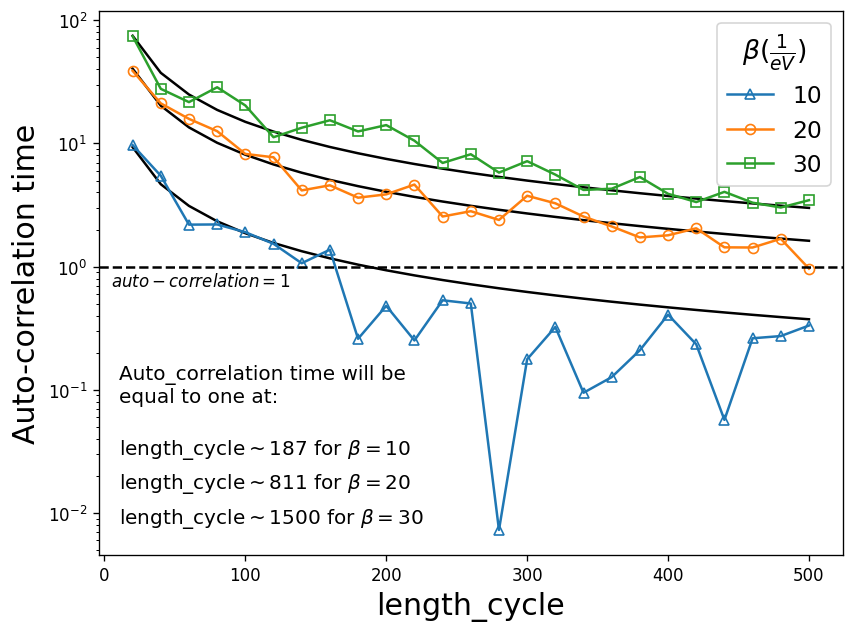

In [33]:
# Define the function for fitting a curve
def func(x, a):
     return a* 1/(x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
marker=['-^', '-o', '-s']
for b in range(len(betas)):
    auto_corr_time = []
    for j in range(len(length_cycle)):
        R = HDFArchive('../../../data/len_cyc_b%i/half-U-lc%i.h5'%(betas[b], length_cycle[j]), 'r')
        auto_corr_time.append(R['a0'])
    optimizedParameters, pcov = opt.curve_fit(func, length_cycle, auto_corr_time);      # Fit the curve
    ax.plot(length_cycle, func(length_cycle, *optimizedParameters), color='k');
    ax.plot(length_cycle, auto_corr_time, marker[b], fillstyle="none", label='%i'%betas[b])
    ax.text(10, 0.03/(1.9**b), r'length_cycle$\sim %i$ for $\beta=%i$'%(math.ceil(optimizedParameters), betas[b]), fontsize=12)
ax.set_yscale("log")
ax.text(10, 0.08, 'Auto_correlation time will be\nequal to one at:', fontsize=12)
ax.set_ylabel('Auto-correlation time',fontsize=18)
ax.set_xlabel('length_cycle',fontsize=18)
plt.legend(title=r'$\beta(\frac{1}{eV})$', title_fontsize=16, fontsize=14)
ax.axhline(y=1, linestyle='--', color='k')
ax.text(5, 0.7, '$auto-correlation = 1$', fontsize = 10)
plt.show()

We observe that for example at $\beta=10$, the converged value of `length_cycle` (i.e. when `auto-correlation time` reaches one) is roughly 187. The calculation here has been performed for a fixed value of `n_cycles` and `n_warmup_cycles` , whereas they should ideally be increased with increasing $\beta$. 

## Accuracy

### 1. `n_warmup_cycles`
The system needs to be thermalized first, i.e. for the first few thousand cycles (`n_warmup_cycles`) we don't make measurements. In order to have an estimate of how many cycles are needed for thermalization, we set `n_warmup_cycle` to be zero in the solver and plot the `average_order` versus the number of cycles. This way measurements are made from the beginning and the number of cycles at which the `average_order` starts to saturate is a good estimate for `n_warmup_cycles`.

In [ ]:
t = 1.0    # Half bandwidth
betas = [10, 50, 100]
n_loops = 1
U = 2.0
mu = 0.0
n_cycles = np.arange(100,8000,100)

for b in range(len(betas)):
    if not os.path.exists('../../../data/warm_up_b%i'%betas[b]):
        os.makedirs('../../../data/warm_up_b%i'%betas[b])

    for j in range(len(n_cycles)):
        S = Solver(beta = betas[b], gf_struct = [('up',1), ('down',1)])
        S.G_iw << SemiCircular(2*t)
        # DMFT loop with self-consistency
        for i in range(n_loops):
            print("\n\nIteration = %i / %i" % (i+1, n_loops))
            # Symmetrize the Green's function and use self-consistency
            g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
            for name, g0 in S.G0_iw:
                g0 << inverse( iOmega_n + U/2.0 - mu - t**2 * g )

                # Solve the impurity problem
            S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
                n_cycles  = n_cycles[j],                   # Number of QMC cycles
                length_cycle = 200,                        # Number of Monte Carlo moves in a cycle
                n_warmup_cycles = 0,                       # Warmup cycles
                )
            # Save iterations in archive
            with HDFArchive('../../../data/warm_up_b%i/half-U-wu%i.h5'%(betas[b], n_cycles[j])) as A:
                A['a%i'%i] = S.auto_corr_time
                A['b%i'%i] = S.average_order

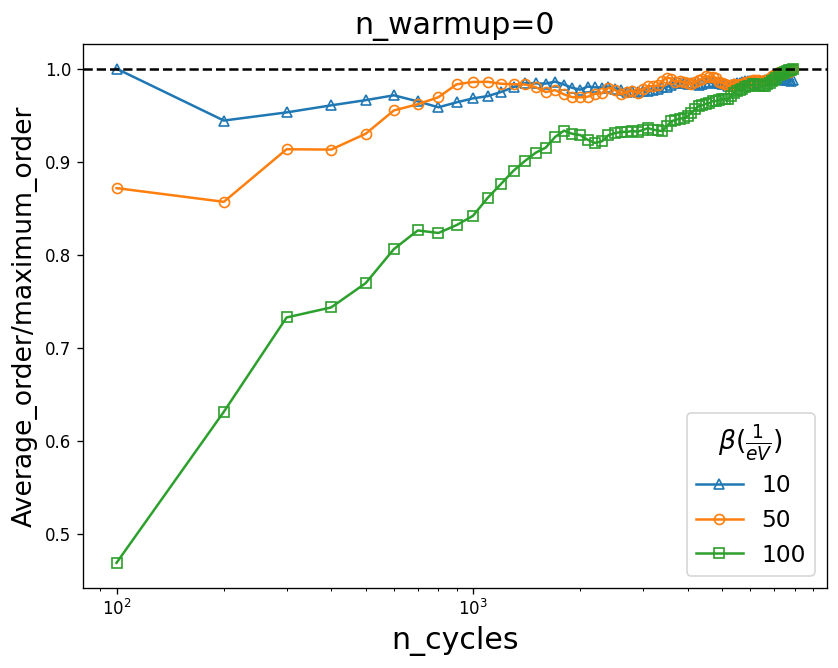

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
marker=['-^', '-o', '-s']

for b in range(len(betas)):
    average_order = []
    for j in range(len(n_cycles)):
        R = HDFArchive('../../../data/warm_up_b%i/half-U-wu%i.h5'%(betas[b], n_cycles[j]), 'r')
        average_order.append(R['b0'])
    average_order=list(map(lambda x: x/max(average_order), average_order))
    ax.plot(n_cycles, average_order, marker[b], fillstyle="none", label='%i'%betas[b])
ax.set_xscale("log")
ax.set_ylabel('Average_order/maximum_order', fontsize=16)
ax.set_xlabel('n_cycles', fontsize=18)
ax.set_title('n_warmup=0', fontsize=18)
ax.axhline(y=1, linestyle='--', color='k')
plt.legend(title=r'$\beta(\frac{1}{eV})$', title_fontsize=16, fontsize=14)
plt.show()

The graph shows that for example at $\beta=50$ almost 1000 `n_warmup_cycles` are enough to thermalize the system, but for beta=100 the thermalization is much slower. Again `length_cycles` is kept fixed here whereas it varies for different temperatures.

### 2. `n_cycles`
The Green's function in imaginary time, $G(\tau$), obtained from the solver for different number of `n_cycles` is plotted. Converged values of `length_cycle` and `n_warmup_cycles` are used from the previous tests. The Monte Carlo error should decay as $\sim$1/sqrt(`n_cycles`). 

In [ ]:
if not os.path.exists('../../../data/n_cycles_b10'):
    os.makedirs('../../../data/n_cycles_b10')
t = 1.0   # Half bandwidth
beta = 10
n_loops = 1
U = 2.0
n_cycles = [32000, 64000, 128000, 256000, 512000, 1024000, 2048000]

for j in range(len(n_cycles)):
    print('n_cycles =', n_cycles[j])
    S = Solver(beta = beta, gf_struct = [('up',1), ('down',1)])
    S.G_iw << SemiCircular(2*t)

    for i in range(n_loops):
    
        print("\n\nIteration = %i / %i" % (i+1, n_loops))
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),     # Local Hamiltonian 
            n_cycles  = n_cycles[j],                     # Number of QMC cycles
            length_cycle = 187,                          # Number of Monte Carlo moves in a cycle
            n_warmup_cycles = 2000,                      # Warmup cycles
            )
    
        # Save iterations in archive
        with HDFArchive('../../../data/n_cycles_b10/half-U-nc%ik.h5'%(n_cycles[j]/1000)) as A:
            A['Gtau-%i'%i] = S.G_tau

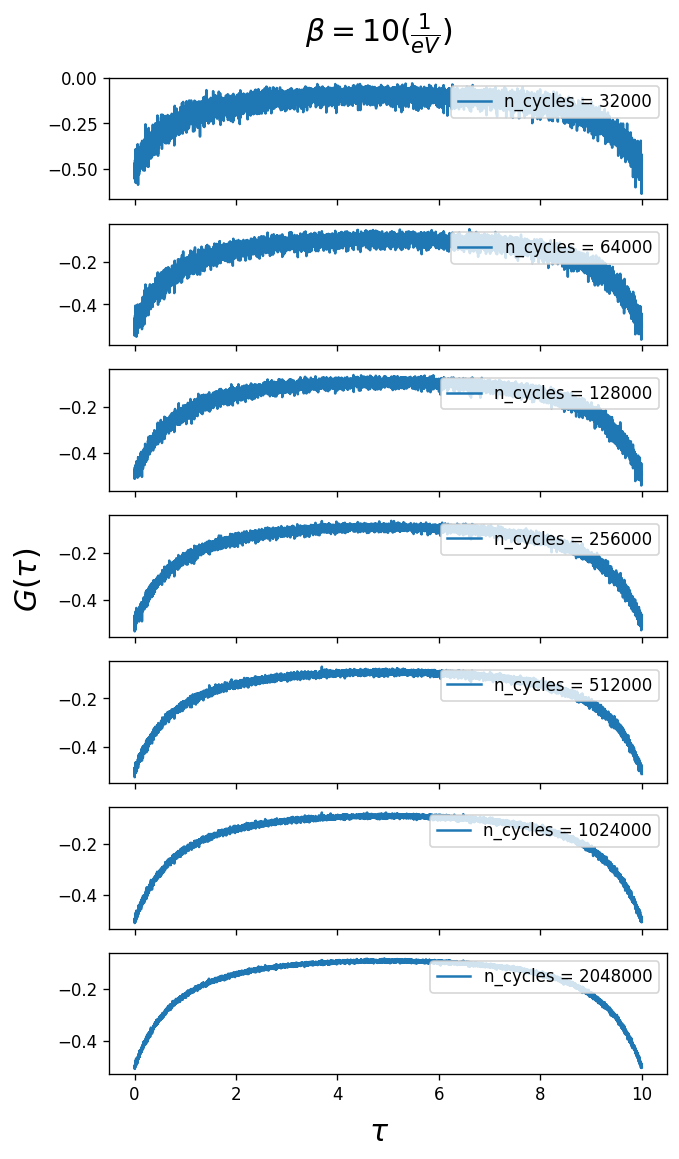

In [38]:
fig, ax = plt.subplots(7, 1, figsize=(6, 11), sharex=True)

for j in range(len(n_cycles)):
    R = HDFArchive('../../../data/n_cycles_b10/half-U-nc%ik.h5'%(n_cycles[j]/1000), 'r')
    ax[j].oplot(R['Gtau-0']['up'].real, '-', label=r"n_cycles = %i"%n_cycles[j])
    ax[j].set_ylabel('')
    ax[j].set_xlabel('')

fig.supylabel(r'$G(\tau)$', x=-0.01, fontsize="18")
fig.supxlabel(r'$\tau$', y= 0.07, fontsize="18")
fig.suptitle(r'$\beta=10 (\frac{1}{eV})$', y=0.93, fontsize="18")
plt.show()

As you can see larger `n_cycles` give a smoother $G(\tau$). It depends on the user's choice as to how large `n_cycles` should be. But keep in mind that the error in $G(\tau$)  is a good indicator of the convergence of all other measurements.

### 3. `n_iw`

The number of Matsubara frequencies used for the Green’s functions. The Green's function should decay to zero for large $i\omega_n$, and capturing this behavior correctly is important for Fourier Transforms and physicality. Here, we plot the density, `n`, of the Green's function for different sizes of the frequency mesh. The size of the Matsubara frequency mesh is important when calculating the density `n`:

The definition of density is $n = \langle c^\dagger c\rangle$

and $\lim_{\tau\to 0} G(\tau) = n$

$G(\tau) = -\langle T c(\tau)c^\dagger\rangle = \langle T c^\dagger c(\tau)\rangle \rightarrow G(\tau=0^-) = \langle c^\dagger c\rangle = n$

The Fourier transform of $G(\tau=0^-)$ is the sum of $G(i\omega_n)$ over Matsubara frequencies which is equal to the density.

$G(\tau=0^-)=\sum_{i\omega_n}{e^{i\omega_n0^-}G(i\omega_n)}=\sum_{i\omega_n}{G(i\omega_n)}$

$\Rightarrow $ $n=\sum_{i\omega_n}{G(i\omega_n)}$

Therefore density converges only if enough number of Matsubabra frequencies `n_iw` are kept in the mesh.

 Error = 0.000665894
 Please make sure you treat the constant offset analytically!
 Error = 0.00528623
 Please make sure you treat the constant offset analytically!


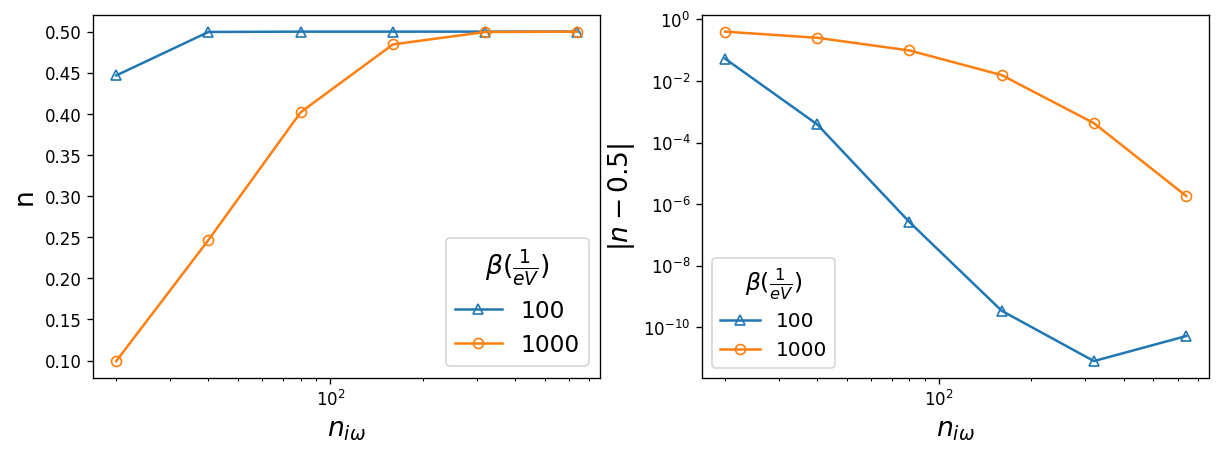

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
D = 1.5  # Half bandwidth
beta = [100, 1000]
n_max = [20, 40, 80, 160, 320, 640] # Size of the Matsubara frequency mesh 
marker=['-^', '-o']
for i in range(len(beta)):
    density = []
    for j in range(len(n_max)):
        iw_mesh = MeshImFreq(beta=beta[i], S='Fermion', n_max=n_max[j])
        G = Gf(mesh=iw_mesh, target_shape=[])
        G << SemiCircular(D)
        density.append(G.density())
    ax[0].set_xscale("log")
    ax[0].plot(n_max, density, marker[i], fillstyle="none", label=beta[i])
    density = list(map(lambda x: x - 0.5, density))
    density = list(map(abs, density))
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].plot(n_max, density, marker[i], fillstyle="none", label=beta[i])

ax[0].legend(title=r'$\beta(\frac{1}{eV})$', title_fontsize=16, fontsize=14) 
ax[0].set_xlabel('$n_{i\omega}$', fontsize=16) 
ax[0].set_ylabel('n', fontsize=16)
ax[1].set_ylabel('$|n-0.5|$', fontsize=16)
ax[1].legend(title=r'$\beta(\frac{1}{eV})$', title_fontsize=14, fontsize=12)
ax[1].set_xlabel(r'$n_{i\omega}$', fontsize=16)
plt.show()

The warning message printed is a hint that the frequency mesh is too small. Since we are working with the semi-circular density of states, the density converges to 0.5. The error on `n` is plotted on the right which shows that density converges with 320 Matsubara frquencies in the mesh.

All we have worked with so far have been non-interacting cases. However interaction can renormalize the shape of the Green's function, in which case it's better to directly investigate the Green's function instead of its density. It can be said that there are enough numbers of Matsubara frequency in the mesh, if the Green's function is in the $\frac{1}{\omega}$ decay region (i.e. if the tail of the Green's function is close to zero) for each frequency mesh.

Below is an example of demonstrating the convergence by looking at the Green's function (still for the non-interacting case).

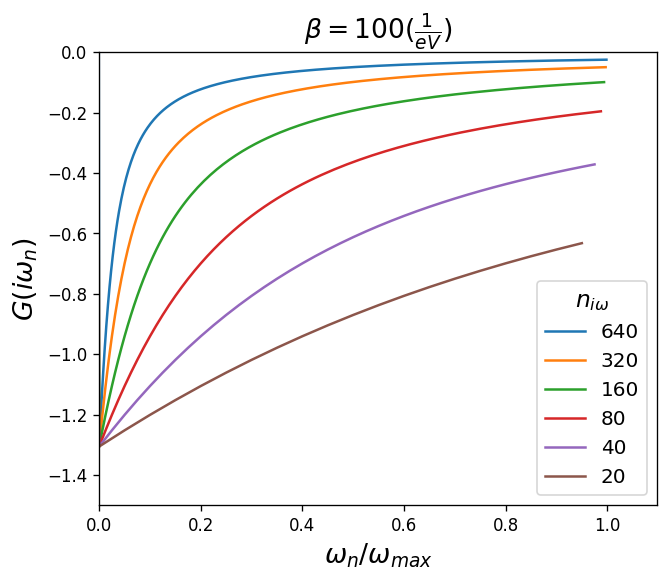

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
D = 1.5  # Half bandwidth
beta = 100
n_max = [640, 320, 160, 80, 40, 20]
for j in range(len(n_max)):
    a = np.arange(-n_max[j],n_max[j])
    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_max[j])
    G = Gf(mesh=iw_mesh, target_shape=[1,1])
    G << SemiCircular(D)
    ax.plot(a/n_max[j], G.imag.data[:,0], label=n_max[j])

ax.set_xlim(0,)
ax.set_ylim(-1.5,0)
ax.legend(title=r'$n_{i\omega}$', title_fontsize=14, fontsize=12)
ax.set_ylabel("$G(i\omega_n)$", fontsize=16)
ax.set_xlabel("$\omega_n/\omega_{max}$", fontsize=16)
ax.set_title(r'$\beta = %i (\frac{1}{eV})$'%beta, fontsize=16)
plt.show()

Here the mesh with 640 frequencies is the best choice.

### 4. `n_l`

The number of Legendre polynomials to use in accumulations of the Green’s function. Representing the Green's function in terms of Legendre polynomials is a compact basis representation described in [Ref](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.075145). 

$G(\mathcal{l})=\sqrt{2l+1}\int_0^{\beta}{d\tau}P_l[x(\tau)]G(\tau)$    

where $x(\tau)=2\tau/\beta -1$ and $G(l)$ denotes the coefficients of $G(\tau)$ in Legendre basis.

We first need to define a function that transforms the Green's function from imaginary time domain to Legendre basis.

In [14]:
from triqs.gf.tools import fit_legendre

def ImTime_to_Legendre(G_tau, order=100, G_l_cut=1e-19):
    """ Filter binned imaginary time Green's function
    using a Legendre filter of given order and coefficient threshold.
    """

    g_l = fit_legendre(G_tau, order=order)
    g_l.data[:] *= (np.abs(g_l.data) > G_l_cut)
    g_l.enforce_discontinuity(np.identity(G_tau.target_shape[0]))

    return g_l

Here we create a Green's function in imaginary frequency and initiallize it with semi-circular density of states. Then we apply Fourier transform on it to enter the imaginary time domain. Finally we use the function defined in the previous cell to transform $G(\tau)$ to Legendre basis.

In [15]:
beta=100
tau_mesh = MeshImTime(beta=beta, S='Fermion', n_max=1000)
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=200)
gw = Gf(mesh=iw_mesh, target_shape=[1,1])
gw << SemiCircular(half_bandwidth = 1)
gtau = make_gf_from_fourier(gw)
gl = ImTime_to_Legendre(gtau, order=50, G_l_cut=1e-19)

The cell below separates the odd and even parts of the Legendre Green's function and the plot tells us how many Legendre plynomials we need to keep in our calcualtion. The cut-off point determines the error on $G(l)$ and the solver more or less. The coefficients for odd `l` must be zero due to particle-hole symmetry.

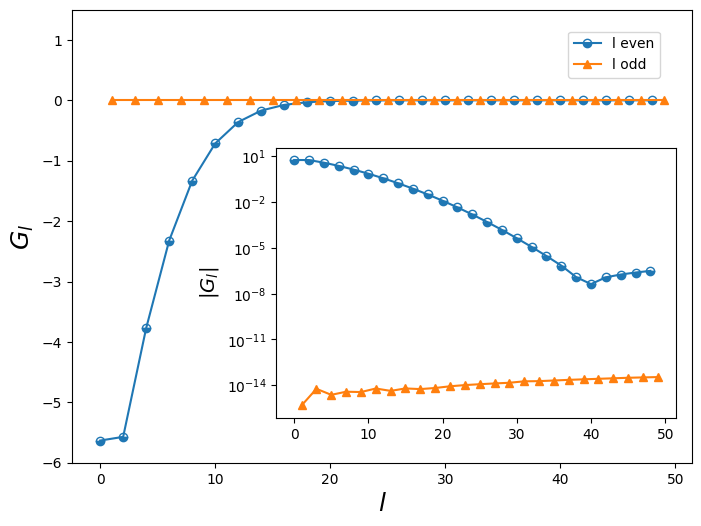

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 6))
left, bottom, width, height = [0.38, 0.2, 0.5, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
d_even=[]
d_odd=[]
dim=gl.data.shape[0]
x_even=np.arange(0,dim,2)
x_odd=np.arange(1,dim,2)
for i in range(0,dim,2):
    d_even.append(gl.real.data[i,0][0])
for k in range(1,dim,2):
    d_odd.append(gl.real.data[k,0][0])
ax1.plot(x_even, d_even, marker=MarkerStyle('o', fillstyle='bottom'), label='l even')
ax1.plot(x_odd, d_odd, '-^', label='l odd')
d_even_abs= list(map(abs, d_even))
d_odd_abs= list(map(abs, d_odd))
ax2.plot(x_even, d_even_abs, marker=MarkerStyle('o', fillstyle='bottom'))
ax2.plot(x_odd, d_odd_abs, '-^')
pyplot.yscale('log')
ax1.set_ylim(-6,1.5)
ax1.legend(loc=(0.8,0.85))
ax1.set_xlabel('$l$', fontsize=18)
ax1.set_ylabel('$G_l$', fontsize=18)
ax2.set_ylabel('$|G_l|$', fontsize=14)
plt.show()

From the graph it is clear that 40 coefficients (`l`) is enough to reach convergence. If Monte Carlo solver is used instead, you will see that $|G(l)|$ is a lot noisier after the drop. This can be efficiently used as a noise filter by cutting the number of coefficients after $G(l)$ reaches its minimum value.

### 5. `n_tau`
Number of imaginary time points used for the Green's function. The CTHYB solver is calculating the Green's function at time differences that are randomly sampled, $G(\tau_i-\tau_j)$ (where $\tau_i$ and $\tau_j$ are randomly chosen between 0 and $\beta$). Every $\tau$ value of the grid is associated with a bin of a given width. If the number of $\tau$ points that fall into each bin is small (or in other words there are a lot of bins, `n_tau` is large) then the error in that bin will be large. Therefore, the plot of $G(\tau)$ will show a lot of noise as `n_tau` is increased. However this does not matter because applying a Fourier transform on the Green's function sums over all the bins [and averages out the error](?). In fact `n_tau` should be as large as possible.

In [ ]:
import os
if not os.path.exists('../../../data/ntau-b10'):
    os.makedirs('../../../data/ntau-b10')
    
# Parameters of the model
t = 1.0
beta = 10
n_loops = 1
U = 2.0
n_tau = [101, 1001, 10001]
# Construct the impurity solver

for j in range(len(n_tau)):
    # n_iw=math.floor((1/8)*n_tau[j])
    print('n_tau =', n_tau[j])
    S = Solver(beta = beta, n_iw=50, n_tau=n_tau[j], gf_struct = [('up',1), ('down',1)])
    # This is a first guess for G
    S.G_iw << SemiCircular(2*t)

    for i in range(n_loops):
        
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
            n_cycles  = 256000,                           # Number of QMC cycles
            length_cycle = 200,
            n_warmup_cycles = 4000,                      # Warmup cycles
            )
    
        # Save iteration in archive
        with HDFArchive("../../../data/ntau-b10/half-U-ntau%i.h5"%n_tau[j]) as A:
            A['Gtau-%i'%i] = S.G_tau
            A['G-%i'%i] = S.G_iw
            A['Sigma-%i'%i] = S.Sigma_iw

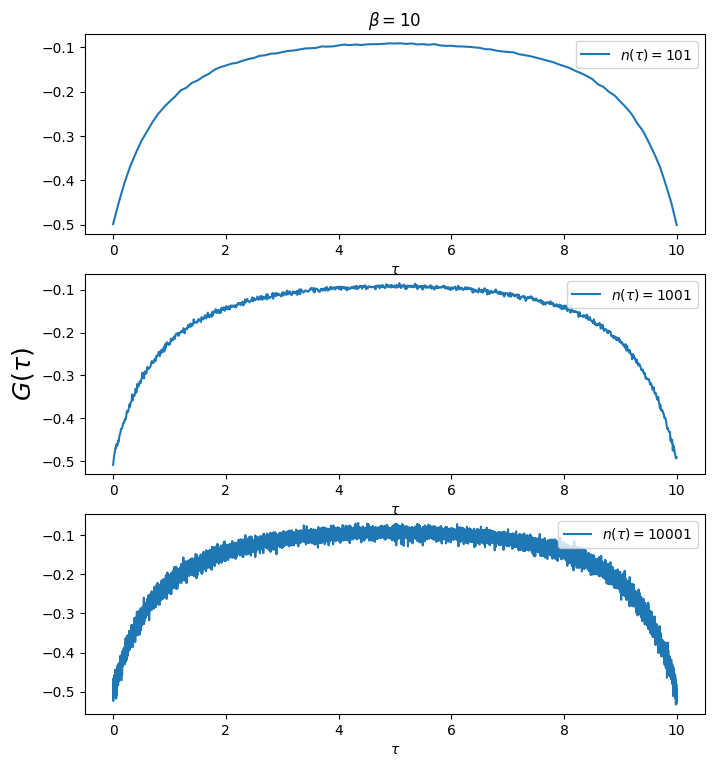

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(8, 9))
n_tau = [101, 1001, 10001]
for j in range(len(n_tau)):
    A1 = HDFArchive("../../../data/ntau-b10/half-U-ntau%i.h5"%n_tau[j], 'r')
    ax[j].oplot(A1['Gtau-0']['up'].real, '-', label=r"$n(\tau) = %i$"%n_tau[j])
    ax[j].set_ylabel('')
ax[1].set_ylabel(r'$G(\tau)$', fontsize="18")
ax[0].set_title(r'$\beta=10$')
plt.show()

Using DLR (Discrete Lehmann representation) solves the problem of finding the best value for `n_tau`. According to [Ref](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.105.235115), a Green's function can be represented as a finite sum of exponentials:

$G(\tau)=\sum_i^N{g_ie^{-\partial_i\tau}}$

$g_i$ will saturate as a function of `n_tau`. The DLR fit on $G(\tau)$ will stabilize at a value of `n_tau` which is what we are after.

Applying Fourier transform on the Green's function to go from imaginary time to imaginary frequency domain also shows that it is better to work with larger `n_tau`. As can be seen from the graph, for small `n_tau` the Green's function crosses zero which is not physical. 

In [20]:
from triqs.gf import Fourier
from triqs.gf import make_gf_from_fourier

[Direct Fourier] WARNING: The imaginary time mesh is less than six times as long as the number of positive frequencies.
This can lead to substantial numerical inaccuracies at the boundary of the frequency mesh.


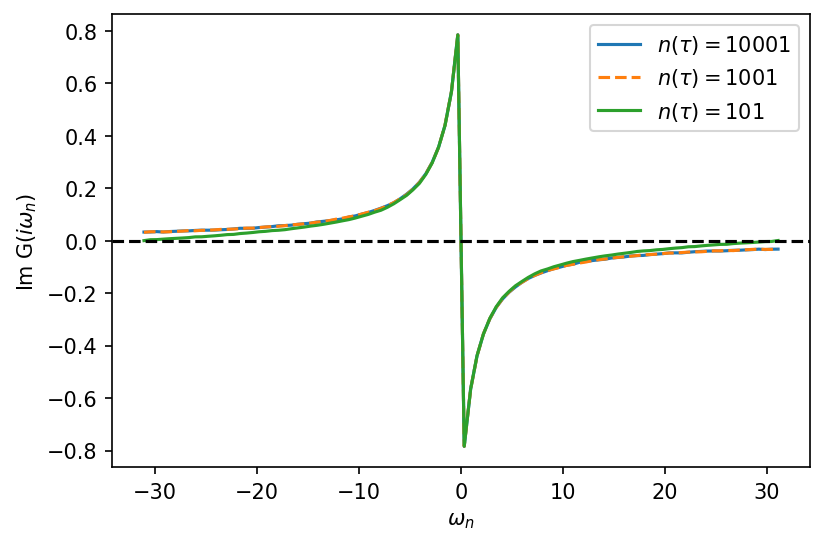

In [21]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(6, 4))
iw_mesh = MeshImFreq(beta=10, S='Fermion', n_max=50)
gf_struct = [('g',1)]
ls=['-', '--', '-']
Giw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
n_tau = [10001, 1001, 101]
for j in range(len(n_tau)):
    A1 = HDFArchive("../../../data/ntau-b10/half-U-ntau%i.h5"%n_tau[j], 'r')
    Giw << Fourier(A1['Gtau-0'])
    ax.oplot(Giw.imag, label=r"$n(\tau) = %i$"%n_tau[j], linestyle=ls[j])
ax.axhline(y=0, linestyle='--', color='k')
plt.show()